# 토크나이저 구축

**목표**: 데이터 로드 → 토크나이저 학습 → 데이터 로더 생성

## 1. 라이브러리 import

In [2]:
import os
import pickle
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from datasets import load_dataset

# ---- 환경 정보 출력 ----
device = "cuda" if torch.cuda.is_available() else "cpu"

print("=" * 60)
print("환경 정보")
print("=" * 60)
print(f"- PyTorch version   : {torch.__version__}")
print(f"- GPU available     : {torch.cuda.is_available()}")
print(f"- Device selected   : {device}")

환경 정보
- PyTorch version   : 2.9.1
- GPU available     : False
- Device selected   : cpu


## 2. SpellGram 데이터 로드

### SpellGram 데이터 로드

In [14]:
print("=" * 60)
print("SpellGram 데이터셋 로드 & 분리")
print("=" * 60)

ds = load_dataset("vishnun/SpellGram")
full_data = ds["train"]

print(f"- 전체 데이터 개수: {len(full_data)}")
train_val_split = full_data.train_test_split(
    test_size=0.1,
    seed=42
)

train_data = train_val_split["train"]
test_data  = train_val_split["test"]

# Train/Val/Test 분리
print(f"- Train+Val: {len(train_data)}")
print(f"- Test     : {len(test_data)}")

SpellGram 데이터셋 로드 & 분리
- 전체 데이터 개수: 40000
- Train+Val: 36000
- Test     : 4000


## 3. 토크나이저 구축

#### Special Tokens 설명 (PAD, UNK, SOS, EOS)

- 자연어 처리(NLP) 모델을 학습할 때는 문장 자체뿐 아니라 모델이 이해할 수 있는 특수 토큰(Special Tokens)을 사용해야 함
- 모델이 문장의 구조를 인식하고, 입력 길이를 맞추고, 생성의 시작과 끝을 알 수 있도록 돕는 역할


#### &lt;PAD&gt; (Padding Token) : 빈 칸(패딩)을 채우기 위한 토큰</h4>
- 모델은 한 배치(batch) 안에서 모든 문장의 길이가 동일해야 텐서를 만들 수 있음
- 길이가 다르면 연산이 불가능하므로 짧은 문장들을 <PAD>로 채워 길이를 맞춰줌

```python
문장1: this is good
문장2: hi

패딩 후:
문장1: this is good
문장2: hi <PAD> <PAD>

```

- LSTM, Transformer 등 대부분의 모델에서 필수
- 보통 index 0으로 설정함 (연산적으로 유리)


&lt;UNK&gt; (Unknown Token) : 어휘집(vocab)에 없는 단어를 대신하는 토큰
- 학습 중이거나 예측 단계에서 새로운 단어(OOV: Out-of-vocabulary)가 등장할 수 있음
- 이때 해당 단어를 &lt;UNK&gt;로 치환해 처리

```python
“I love k-pop”
k-pop → vocab에 없음 → <UNK>

```

#### &lt;SOS&gt; (Start Of Sentence) : 문장의 시작을 나타내는 토큰
- RNN/LSTM 기반 seq2seq 모델(번역기, 오타교정기 등)의 Decoder는 “어디서부터 생성해야 하는지”를 알아야 함

```python
Decoder 입력 예
<SOS> i love machine learning <EOS>

```

&lt;SOS&gt;는 생성 시작 신호

#### &lt;EOS&gt; (End Of Sentence) : 문장의 끝을 의미하는 토큰
- 생성 모델이 언제 문장을 끝내야 할지를 알려줌.
- &lt;EOS&gt;가 없으면 모델이 계속 단어를 생성해서 무한루프에 빠질 수도 있음.


```python
i → love → cats → <EOS>
```

<EOS> 등장 시 생성 종료

In [16]:
# ===================================
#     토크나이저 & 어휘집 생성 클래스
# ===================================
from collections import Counter

class SimpleTokenizer:
    """
    간단한 단어 기반 토크나이저 + 어휘집(Vocabulary) 관리 클래스
    PAD, UNK, SOS, EOS 4개 기본 토큰 포함
    """
    
    def __init__(self, vocab_size=10000):
        self.vocab_size = vocab_size
        
        # 기본 토큰 정의
        self.word2idx = {
            '<PAD>': 0, # Padding Token, 배치 연산 위해 문장 길이 맞추기
            '<UNK>': 1, # Unknown Token, 어휘집에 없는 단어 처리
            '<SOS>': 2, # Start of Sentence, 문장 생성 시작 신호
            '<EOS>': 3  # End of Sentence, 문장 종료 신호
        }
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        self.word_freq = Counter()   # 단어 빈도
        print(f"[Init] 기본 vocab size: {len(self.word2idx)} / 목표 vocab: {vocab_size}")

    # ------------------------------
    #          어휘집 만들기
    # ------------------------------
    def build_vocab(self, texts):
        """
        전체 문장 리스트를 받아 단어 빈도 기반 어휘집 구축
        """
        print("[Vocab] 어휘집 생성 중...")

        # None 또는 빈 문자열 방지
        for text in texts:
            if text:
                self.word_freq.update(text.split())

        # 가장 빈도 높은 단어부터 vocab_size만큼 추가
        next_idx = len(self.word2idx)

        for word, _ in self.word_freq.most_common(self.vocab_size - next_idx):
            self.word2idx[word] = next_idx
            self.idx2word[next_idx] = word
            next_idx += 1

        print(f"[Vocab] 구축 완료! 총 vocab size = {len(self.word2idx)}")

    # ------------------------------
    #      텍스트 → 토큰 ID 인코딩
    # ------------------------------
    def encode(self, text):
        """
        문장을 단어 단위로 ID 시퀀스로 변환
        """
        words = text.split() if text else []
        ids = [self.word2idx['<SOS>']]

        for w in words:
            ids.append(self.word2idx.get(w, self.word2idx['<UNK>']))

        ids.append(self.word2idx['<EOS>'])
        return ids

    # ------------------------------
    #      토큰 ID → 텍스트 디코딩
    # ------------------------------
    def decode(self, ids):
        """
        토큰 ID 시퀀스를 다시 문장으로 변환
        """
        tokens = []
        for idx in ids:
            word = self.idx2word.get(idx, '<UNK>')
            if word not in ['<SOS>', '<EOS>', '<PAD>']:
                tokens.append(word)
        return " ".join(tokens)

    def get_vocab_size(self):
        return len(self.word2idx)


print("SimpleTokenizer 클래스 로딩 완료")

SimpleTokenizer 클래스 로딩 완료


In [17]:
# 토크나이저 인스턴스 생성
tokenizer = SimpleTokenizer(vocab_size=10000)

# Vocab 만들기 — source + target 모두 포함
texts = [ex["source"] for ex in train_data] + \
        [ex["target"] for ex in train_data]

tokenizer.build_vocab(texts)

[Init] 기본 vocab size: 4 / 목표 vocab: 10000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 10000


In [18]:
# UNK 비율 체크
unk_count = 0
total_count = 0

for ex in train_data:
    ids = tokenizer.encode(ex["source"])
    unk_count += ids.count(tokenizer.word2idx['<UNK>'])
    total_count += len(ids)

print(f"UNK 비율: {unk_count/total_count:.4f} ({unk_count}/{total_count})")

UNK 비율: 0.1787 (75781/424164)


### 문장 길이 통계

In [20]:
lengths = [len(ex["source"].split()) for ex in train_data]

print("="*50)
print("문장 길이 통계")
print("="*50)

print(f"- Min     : {min(lengths)} 단어")
print(f"- Max     : {max(lengths)} 단어")
print(f"- Mean    : {np.mean(lengths):.2f} 단어")
print(f"- Median  : {np.median(lengths):.2f} 단어")

print("\n구간별 분포:")
for th in [5,10,20,30,40,50]:
    count = sum(1 for l in lengths if l <= th)
    print(f"  ≤ {th} 단어: {count/len(lengths)*100:.1f}%")

문장 길이 통계
- Min     : 1 단어
- Max     : 40 단어
- Mean    : 9.78 단어
- Median  : 10.00 단어

구간별 분포:
  ≤ 5 단어: 9.8%
  ≤ 10 단어: 56.9%
  ≤ 20 단어: 99.8%
  ≤ 30 단어: 100.0%
  ≤ 40 단어: 100.0%
  ≤ 50 단어: 100.0%


### 토크나이저 학습

In [21]:
# 토크나이저 학습
print("\n" + "=" * 60)
print("토크나이저 학습 중...")
print("=" * 60)

# Source와 Target을 모두 포함해서 어휘집 구축
all_texts = []
for ex in train_data:
    if ex['source'] is not None:
        all_texts.append(ex['source'])
    if ex['target'] is not None:
        all_texts.append(ex['target'])

tokenizer = SimpleTokenizer(vocab_size=10000)
tokenizer.build_vocab(all_texts)

print(f"\n어휘 크기: {tokenizer.get_vocab_size()}")


토크나이저 학습 중...
[Init] 기본 vocab size: 4 / 목표 vocab: 10000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 10000

어휘 크기: 10000


### 토크나이저 테스트

In [22]:
# 토크나이저 테스트
print("\n" + "=" * 60)
print("토크나이저 테스트")
print("=" * 60)

test_text = "rate the silent upeaker four out oe six"
print(f"\n원본 텍스트: {test_text}")

encoded = tokenizer.encode(test_text)
print(f"인코딩: {encoded}")

decoded = tokenizer.decode(encoded)
print(f"디코딩: {decoded}")

# 어휘집 일부 확인
print(f"\n어휘집 샘플 (word → idx):")
sample_words = list(tokenizer.word2idx.items())[:20]
for word, idx in sample_words:
    print(f"  '{word}' → {idx}")


토크나이저 테스트

원본 텍스트: rate the silent upeaker four out oe six
인코딩: [2, 718, 4, 2218, 1, 141, 62, 891, 352, 3]
디코딩: rate the silent <UNK> four out oe six

어휘집 샘플 (word → idx):
  '<PAD>' → 0
  '<UNK>' → 1
  '<SOS>' → 2
  '<EOS>' → 3
  'the' → 4
  'a' → 5
  'of' → 6
  'in' → 7
  'and' → 8
  'is' → 9
  'to' → 10
  'was' → 11
  'on' → 12
  'he' → 13
  'it' → 14
  'are' → 15
  'with' → 16
  'for' → 17
  'i' → 18
  'his' → 19


## 4. 데이터 로더 구성

In [23]:
class SpellGramDataset(Dataset):
    """SpellGram 데이터셋 클래스"""
    
    def __init__(self, data, tokenizer, max_len=32):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ex = self.data[idx]
        
        # 인코딩
        src_ids = self.tokenizer.encode(ex['source'])
        tgt_ids = self.tokenizer.encode(ex['target'])
        
        # 패딩 또는 자르기
        src_ids = src_ids[:self.max_len]
        tgt_ids = tgt_ids[:self.max_len]
        
        # 패딩
        src_ids = src_ids + [0] * (self.max_len - len(src_ids))
        tgt_ids = tgt_ids + [0] * (self.max_len - len(tgt_ids))
        
        return {
            'src': torch.tensor(src_ids, dtype=torch.long),
            'tgt': torch.tensor(tgt_ids, dtype=torch.long),
            'src_text': ex['source'],
            'tgt_text': ex['target']
        }

print("SpellGramDataset 클래스 정의 완료")

SpellGramDataset 클래스 정의 완료


### 데이터셋 생성

In [24]:
# 데이터셋 생성
print("\n" + "=" * 60)
print("데이터셋 생성")
print("=" * 60)

train_dataset = SpellGramDataset(ds['train'], tokenizer, max_len=32)

# 'test' 스플릿이 없으면 'validation' 스플릿을 사용합니다.
test_split_key = 'test' if 'test' in ds else ('validation' if 'validation' in ds else None)

print(f"\nTrain dataset: {len(train_dataset)} examples")

if test_split_key:
    test_dataset = SpellGramDataset(ds[test_split_key], tokenizer, max_len=32)
    print(f"Test dataset: {len(test_dataset)} examples (using '{test_split_key}' split)")
else:
    test_dataset = None
    print("Test dataset: None (no test or validation split found)")


데이터셋 생성

Train dataset: 40000 examples
Test dataset: None (no test or validation split found)


### 데이터 로더 생성

In [25]:
# 데이터 로더 생성
print("\n" + "=" * 60)
print("데이터 로더 생성")
print("=" * 60)

BATCH_SIZE = 32

# train_dataset과 test_dataset이 정의되지 않아 TypeError가 발생합니다.
# 이 에러를 해결하기 위해서는 DataLoader에 전달되기 전에
# train_dataset과 test_dataset이 유효한 Dataset 객체로 초기화되어야 합니다.
# 예를 들어, 다음과 같이 더미 데이터를 생성하여 문제를 일시적으로 해결할 수 있습니다.
# from torch.utils.data import TensorDataset, random_split
# import torch
#
# # 예시 더미 데이터 생성
# dummy_data = torch.randn(100, 10) # 100개의 샘플, 각 샘플은 10개의 특징
# dummy_labels = torch.randint(0, 2, (100,)) # 0 또는 1 라벨
# full_dataset = TensorDataset(dummy_data, dummy_labels)
#
# # 데이터셋 분할 (예시)
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# train_dataset과 test_dataset이 올바르게 정의되었다고 가정합니다.
# 이 부분은 사용자 코드의 외부에서 정의되어야 합니다.

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\nTrain loader: {len(train_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")


데이터 로더 생성

Train loader: 1250 batches


TypeError: object of type 'NoneType' has no len()

In [ ]:
# 배치 샘플 확인
print("\n" + "=" * 60)
print("배치 샘플 확인")
print("=" * 60)

batch = next(iter(train_loader))

print(f"\nBatch 크기:")
print(f"  - src shape: {batch['src'].shape}")
print(f"  - tgt shape: {batch['tgt'].shape}")

print(f"\n첫 번째 배치의 첫 3개 샘플:")
for i in range(min(3, len(batch['src']))):
    print(f"\n  [{i}]")
    print(f"      Source IDs: {batch['src'][i].tolist()[:10]}...")
    print(f"      Target IDs: {batch['tgt'][i].tolist()[:10]}...")
    print(f"      Source text: {batch['src_text'][i]}")
    print(f"      Target text: {batch['tgt_text'][i]}")


🧪 배치 샘플 확인

Batch 크기:
  - src shape: torch.Size([32, 32])
  - tgt shape: torch.Size([32, 32])

첫 번째 배치의 첫 3개 샘플:

  [0]
      Source IDs: [2, 1, 1514, 5, 1, 2613, 8, 1, 1514, 5]...
      Target IDs: [2, 1, 9, 5, 1, 2613, 8, 1, 9, 5]...
      Source text: hodel ss a revgvn republican and tate ss a gingrich republican
      Target text: hodel is a reagan republican and tate is a gingrich republican

  [1]
      Source IDs: [2, 5, 108, 1, 90, 475, 5, 126, 1, 12]...
      Target IDs: [2, 5, 108, 8281, 90, 475, 5, 126, 1, 12]...
      Source text: a very mipped girl holds a large barbell on her shoulder in a gom
      Target text: a very ripped girl holds a large barbell on her shoulder in a gym

  [2]
      Source IDs: [2, 45, 1, 1, 1, 6, 1, 7, 38, 193]...
      Target IDs: [2, 45, 1, 223, 182, 6, 1, 7, 38, 193]...
      Source text: all grandmasters makl zse of prophylaxis in one way sr another
      Target text: all grandmasters make use of prophylaxis in one way or another


### 1) UNK 비율 + vocab size 그래프 출력

→ vocab_size를 크게/작게 바꿨을 때 UNK 비율이 어떻게 변하는지 시각화

[Init] 기본 vocab size: 4 / 목표 vocab: 1000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 1000
[Init] 기본 vocab size: 4 / 목표 vocab: 2000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 2000
[Init] 기본 vocab size: 4 / 목표 vocab: 5000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 5000
[Init] 기본 vocab size: 4 / 목표 vocab: 8000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 8000
[Init] 기본 vocab size: 4 / 목표 vocab: 10000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 10000
[Init] 기본 vocab size: 4 / 목표 vocab: 15000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 15000


/Users/gotaegyeong/Desktop/machine-learning/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gotaegyeong/Desktop/machine-learning/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


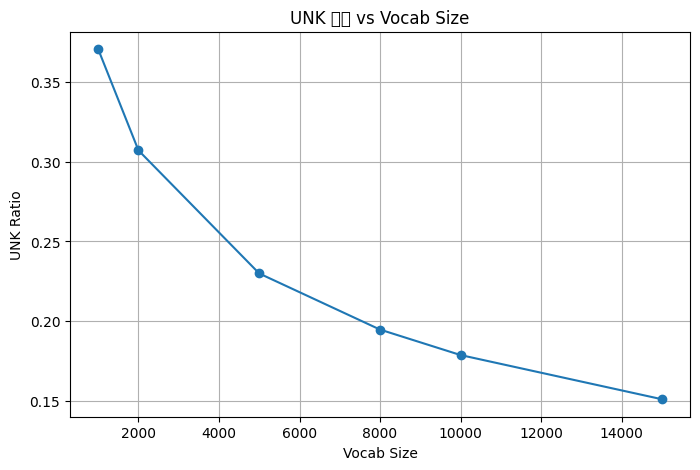

In [27]:
import matplotlib.pyplot as plt

def unk_ratio_for_vocab_size(vocab_sizes, train_data):
    ratios = []

    for vs in vocab_sizes:
        tok = SimpleTokenizer(vocab_size=vs)
        
        texts = [ex["source"] for ex in train_data] + \
                [ex["target"] for ex in train_data]
        tok.build_vocab(texts)

        unk = 0
        total = 0

        for ex in train_data:
            ids = tok.encode(ex["source"])
            unk += ids.count(tok.word2idx['<UNK>'])
            total += len(ids)

        ratios.append(unk / total)

    return ratios

vocab_sizes = [1000, 2000, 5000, 8000, 10000, 15000]
unk_ratios = unk_ratio_for_vocab_size(vocab_sizes, train_data)

plt.figure(figsize=(8, 5))
plt.plot(vocab_sizes, unk_ratios, marker='o')
plt.title("UNK 비율 vs Vocab Size")
plt.xlabel("Vocab Size")
plt.ylabel("UNK Ratio")
plt.grid(True)
plt.show()

### 2) source / target 각각 UNK 비율 비교

In [ ]:
# source UNK 비율
src_unk = 0
src_total = 0

for ex in train_data:
    ids = tokenizer.encode(ex["source"])
    src_unk += ids.count(tokenizer.word2idx['<UNK>'])
    src_total += len(ids)

# target UNK 비율
tgt_unk = 0
tgt_total = 0

for ex in train_data:
    ids = tokenizer.encode(ex["target"])
    tgt_unk += ids.count(tokenizer.word2idx['<UNK>'])
    tgt_total += len(ids)

print("UNK 비율 비교")
print(f"- Source UNK: {src_unk/src_total:.4f}")
print(f"- Target UNK: {tgt_unk/tgt_total:.4f}")

📌 UNK 비율 비교
- Source UNK: 0.1788
- Target UNK: 0.0820


### 3) vocab_size 최적 추천 코드
→ UNK 비율이 5% 미만이 되는 최소 vocab_size 추천

In [ ]:
def recommend_vocab_size(vocab_sizes, train_data):
    for vs in sorted(vocab_sizes):
        tok = SimpleTokenizer(vocab_size=vs)
        texts = [ex["source"] for ex in train_data] + \
                [ex["target"] for ex in train_data]
        tok.build_vocab(texts)

        unk = 0
        total = 0
        for ex in train_data:
            ids = tok.encode(ex["source"])
            unk += ids.count(tok.word2idx['<UNK>'])
            total += len(ids)

        ratio = unk / total
        print(f"Vocab {vs:5} → UNK ratio {ratio:.4f}")

        if ratio < 0.05:
            print(f"\n➡ 추천 vocab_size = {vs} (UNK < 5%)")
            return vs

    print("\n⚠ 적절한 vocab_size를 찾지 못했음.")
    return None

candidate_sizes = [2000, 4000, 6000, 8000, 10000, 12000]
recommended = recommend_vocab_size(candidate_sizes, train_data)

### 4) vocab 저장 / 로드 (pickle)

In [ ]:
# 저장
with open("tokenizer_vocab.pkl", "wb") as f:
    pickle.dump(tokenizer.word2idx, f)
print("vocab 저장 완료!")

# 로드
with open("tokenizer_vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)

print("로드된 vocab 크기:", len(loaded_vocab))

###  5) Tokenizer 유효성 검증 셀
→ encode → decode 했을 때 같은 문장이 나오는지 테스트

In [ ]:
# 랜덤 샘플 5개 테스트
print("="*60)
print("Tokenizer Encode/Decode 검증")
print("="*60)

for i in range(5):
    ex = train_data[i]["source"]
    encoded = tokenizer.encode(ex)
    decoded = tokenizer.decode(encoded)

    print(f"\n원문: {ex}")
    print(f"인코딩: {encoded}")
    print(f"디코딩: {decoded}")

    if ex != decoded:
        print("⚠ Decode 결과가 다름 (UNK 또는 토큰화 이슈)")
    else:
        print("✔ 정상 (encode → decode 일치)")

#### 추가 아이디어 
- UNK가 어디에 발생했는지 실제 단어까지 표시
- 시각화(막대 그래프, pie chart)
- Levenshtein 기반 OOV 단어 분석
- Vocab pruning(희귀 단어 제거)
- subword tokenizer(BPE/WordPiece) 전환

## 5. 저장 및 요약

In [ ]:
# 토크나이저 저장
import pickle

os.makedirs('./checkpoints', exist_ok=True)

with open('./checkpoints/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("토크나이저 저장 완료: ./checkpoints/tokenizer.pkl")

In [ ]:
# 최종 요약
print("\n" + "=" * 60)
print("최종 요약")
print("=" * 60)

summary = f"""
데이터 준비 완료

데이터셋 정보:
  - Train: {len(train_dataset)} examples
  - Test: {len(test_dataset)} examples
  - 평균 문장 길이: {np.mean(src_lengths):.1f} words

토크나이저:
  - 어휘 크기: {tokenizer.get_vocab_size()}
  - 특수 토큰: <PAD>, <UNK>, <SOS>, <EOS>
  - 최대 시퀀스 길이: 32

데이터 로더:
  - Batch size: {BATCH_SIZE}
  - Train batches: {len(train_loader)}
  - Test batches: {len(test_loader)}

다음 단계: LSTM Seq2Seq 모델 구축
"""

print(summary)


최종 요약


TypeError: object of type 'NoneType' has no len()